<div>
    <table>
    <tr>
        <th style="text-align: center;">Project</th>
        <td style="text-align: center; width: 200px">CO2 Emissions</td>
        <td colspan="3" rowspan="3" style="text-align: center; width: 200px"><h1>Third Step - Modelling (Regression)</h1></td>
    </tr>
    <tr>
        <th style="text-align: center;">Location</th>
        <td style="text-align: center; width: 200px">-</td>
    </tr>
    <tr>
        <th style="text-align: center;">Date</th>
        <td style="text-align: center; width: 200px">19-Jun-2024</td>
    </tr>
    <tr>
        <th style="text-align: center;">&nbsp;</th>
        <td style="text-align: center; width: 200px">&nbsp;</td>
        <td style="text-align: center; width: 200px">&nbsp;</td>
        <td style="text-align: center; width: 200px">&nbsp;</td>
        <td style="text-align: center; width: 200px">&nbsp;</td>
    </tr>
    <tr>
        <th style="text-align: center;">COHORD:</th>
        <td style="text-align: center; width: 200px">C. ARNAUD</td>
        <td style="text-align: center; width: 200px">&nbsp;</td>
        <td style="text-align: center; width: 200px">&nbsp;</td>
        <td style="text-align: center; width: 200px">&nbsp;</td>
    </tr>
    <tr>
        <th style="text-align: center;">&nbsp;</th>
        <td style="text-align: center;">D. GOMEZ-OCHOA</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
    </tr>
    <tr>
        <th style="text-align: center;">&nbsp;</th>
        <td style="text-align: center;">P. DESHPANDE</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
    </tr>
    <tr>
        <th style="text-align: center;">&nbsp;</th>
        <td style="text-align: center;">R. MARINHO</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
    </tr>
    <tr>
        <th style="text-align: center;">&nbsp;</th>
        <td style="text-align: center;">S. MASOOD</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
        <td style="text-align: center;">&nbsp;</td>
    </tr>
    </table>
</div>

# 1. Purpose

> The purpose of this Calculation note is to perform different regressions methods to try to estimate the CO2 emissions
> based on the available caracteristics present on the dataset obtained in the pre-processing part of this report.
>
> The main objectives are:
>
> - Obtain a regression model that can estimate the CO2 emissions from vehicles caracteristics
> - Compare different methods and propose improvments for low performing estimation models
> - Select the best regression model for this dataset
> 

# 2. Imports

In [31]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))
from co2emissions.config import data_dir

import pandas as pd

In [32]:
import warnings 
warnings.filterwarnings('ignore') # Ignore undesired warnigs

import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, Lasso, lasso_path, LassoCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
import scipy.stats as stats
import  statsmodels.api as sm
import statsmodels.stats.api as sms

import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

plt.rcParams['figure.dpi'] = 120 # Better image quality in matplotlib plots

# 3. Useful Function for the notebook

> The aim of this section is to defined different useful function to simplify the Notebook

> The first function is used to calculate direclty the metric to assess our model (R2, MAE, MSE and RMSE)

In [33]:
def metrics(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):

    # Display R2
    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)
    
    print(f'Score train : {R2_train:.4f}')
    print(f'Score test  : {R2_test:.4f}')
    
    # Display MSE
    MSE_train = mean_squared_error(y_train, y_train_pred)
    MSE_test = mean_squared_error(y_test, y_test_pred)
    
    print(f'MSE train :   {MSE_train:.2f}')
    print(f'MSE test  :   {MSE_test:.2f}')
    
    # Display RMSE
    RMSE_train = mean_squared_error(y_train, y_train_pred, squared = False)
    RMSE_test = mean_squared_error(y_test, y_test_pred, squared = False)
    
    print(f'RMSE train :   {RMSE_train:.2f}')
    print(f'RMSE test  :   {RMSE_test:.2f}')
    
    # Display MAE
    MAE_train = mean_absolute_error(y_train, y_train_pred)
    MAE_test = mean_absolute_error(y_test, y_test_pred)
    
    print(f'MAE train :   {MAE_train:.2f}')
    print(f'MAE test  :   {MAE_test:.2f}')
    
    # Summary Tables of the results
    dic_lr= {'R2': [R2_train, R2_test], 'MAE': [MAE_train, MAE_test], 'MSE' : [MSE_train, MSE_test], 'RMSE' : [RMSE_train, RMSE_test]}
    results_lr = pd.DataFrame(dic_lr, index = ['Train', 'Test'])
    
    results_lr['R2'] = results_lr['R2'].round(decimals=4)
    results_lr[['MAE', 'MSE', 'RMSE']] = results_lr[['MAE', 'MSE', 'RMSE']].round(decimals=2)
    
    return results_lr

> The Second function allow to display the plot between the predicted CO2 Emissions and the real CO2 emissions
>
> And also saves the resuts as pickle and svg. For using in the report and in the presentation.

In [34]:
import pickle
import os

def save_picke_file(obj, relative_path):
    with open(relative_path, 'wb') as f:
        pickle.dump(obj, f)

def plot_results(y_test, y_predicted, title):
    fig = px.scatter(
        x = y_predicted, 
        y = y_test,
        hover_name=df['lib_mrq_utac'][df.year==2015],
        color=df['lib_mrq_utac'][df.year==2015],
        labels={
            'x':'predicted',
            'y':'real',
            'color':'Brand'
        }
    )
    
    fig.update_layout(
        title = f"Predicted vs real: {title}",
        height = 1000,
    )
    
    fig.add_scatter(
        x = [y_test.min(), y_test.max()],
        y = [y_test.min(), y_test.max()],
        name = 'Expected',
        mode = 'lines'
    )
    
    # Y axis scale
    fig['layout']['yaxis']['range']=[0,420]
    
    fig.show()
    # Save image as SVG and pickle files
    save_picke_file(fig, os.path.join('imgs', f'0-{title}.pkl'))
    fig.write_image(os.path.join('imgs',f'0-{title}.svg'), width=1600, height=1000)

> The third function is used to calculate the residues of a Linear Regression model and plot the associated graph to check the homo-sedasticity and normality of the residues

In [35]:
def plot_residues(y_train, y_train_pred):

    # Calculation of the adjustes values and residues of the model
    residues = y_train_pred - y_train
    
    # Centering and reduction of the residues
    residues_norm = (residues - residues.mean()) / residues.std()
    
    # Display of the two graph
    plt.figure(figsize = (20, 10))
    
    # Display of the scatterplot
    plt.subplot(1, 2, 1)
    plt.scatter(x = y_train, y = residues, color = 'darkblue')
    plt.plot((y_train.min(),y_train.max()), (0, 0), lw=3, color = 'orange')
    plt.xlabel('CO2 Emissions')
    plt.ylabel('Residues')
    plt.title("CO2 emissions vs Residues")
    
    # Display of the QQ-plot
    plt.subplot(1, 2, 2)
    stats.probplot(residues_norm, plot = plt)
    
    plt.show();

> The fourth function is used to conduct the statistical test on the residues for homo-sedasticity (Breusch-Pagan test) and normality (the Jarque-Bera test)

In [36]:
def statistical_residues(X_train, y_train, y_train_pred):

    # Calculation of the adjustes values and residues of the model
    residues = y_train_pred - y_train

    # Conduct the Breusch-Pagan test
    names = ['Lagrange multiplier statistic', 'p-value',
             'f-value', 'f p-value']
     
    # Get the test result
    exog = sm.add_constant(X_train, prepend = True)
    lm, lm_p_value, fvalue, f_p_value = sms.het_breuschpagan(residues, exog)

    if lm_p_value < 0.05:
        print(f"Breusch-Pagan test p-value: {lm_p_value}")
        print("p_value < 0.05 therefore the null hypothesis is rejected and we can conclude H1: Hetero-Scedasticity is present")

    else:
        print(f"Breusch-Pagan test p-value: {lm_p_value}")
        print("p_value > 0.05 therefore we can conclude H0: Homo-Scedasticity is present")
    
    
    # Conduct the Jarque-Bera test

    p_val = stats.jarque_bera(residues)[1]
    
    if p_val < 0.05:
        print(f"Jarque-Bera test p-value: {p_val}")
        print("p_value < 0.05 therefore the null hypothesis is rejected and we can conclude H1: Data doesn't follow a normal distribution")

    else:
        print(f"Jarque-Bera test p-value: {p_val}")
        print("p_value < 0.05 therefore we can conclude H0: Data follow a normal distribution")

> The fifth function allow to represent a table with the coeffcient of the Regression model

In [37]:
def coeff_regression(X_train, coef, intercept):
    coeffs = list(coef)
    coeffs.insert(0, intercept)
    
    feats = list(X_train.columns)
    feats.insert(0, 'intercept')
    
    results = pd.DataFrame({'coeffs': coeffs}, index=feats)
    results.coeffs = results.coeffs.round(5)
    print(results[~(results.coeffs == 0)].round(2).to_markdown())

# 3. Initial Dataset

> The initial data set is the one obtained in the pre-processing phase of this project.

In [38]:
# Import of the dataset
df_path = os.path.join(data_dir, '2-cleaned', 'data_phase_2.csv')
df = pd.read_csv(df_path)
df.head(3)

lib_mrq_utac cod_cbr hybride  puiss_max  conso_mixte    co2  co_typ_1  \
0   ALFA ROMEO      ES     non      147.0          7.8  182.0     0.647   
1   ALFA ROMEO      GO     non      125.0          5.1  136.0     0.192   
2   ALFA ROMEO      GO     non      100.0          5.1  134.0     0.066   

      hc    nox  hcnox  masse_ordma_max  year type_of_gearbox nbr_reports  
0  0.052  0.032  0.084           1505.0  2015               M           6  
1  0.021  0.169  0.190           1565.0  2015               M           6  
2  0.026  0.149  0.175           1565.0  2015               M           6

In [39]:
# Display of the information of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103248 entries, 0 to 103247
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lib_mrq_utac     103248 non-null  object 
 1   cod_cbr          103248 non-null  object 
 2   hybride          103248 non-null  object 
 3   puiss_max        103248 non-null  float64
 4   conso_mixte      103248 non-null  float64
 5   co2              103248 non-null  float64
 6   co_typ_1         103248 non-null  float64
 7   hc               103248 non-null  float64
 8   nox              103248 non-null  float64
 9   hcnox            103248 non-null  float64
 10  masse_ordma_max  103248 non-null  float64
 11  year             103248 non-null  int64  
 12  type_of_gearbox  103248 non-null  object 
 13  nbr_reports      103248 non-null  object 
dtypes: float64(8), int64(1), object(5)
memory usage: 11.0+ MB


In [40]:
# Display of the number of variables per year
df.year.value_counts() / len(df)

year
2014    0.462314
2013    0.321391
2015    0.189883
2012    0.026412
Name: count, dtype: float64

> 2015 is around 20% of the dataset, we will later use the data of this year for test and the remaining data for trainning.

In [41]:
# Order by year for later
df = df.sort_values(by='year').reset_index()

# 4. Separation of Variables

In [42]:
# Split of the dataset between numerical and categorical variables
num_vars = df[['puiss_max', 'conso_mixte', 'co2', 'co_typ_1', 'hc', 'nox', 'hcnox', 'masse_ordma_max']]
qlt_vars = df[['cod_cbr', 'hybride', 'type_of_gearbox', 'nbr_reports']]

# Apply of the get_dummies function on the catgorical variavles
qlt_vars = pd.get_dummies(qlt_vars, dtype='int64')

# Display of the first rows of the numerical and categorical variables
display(num_vars.head(3))
display(qlt_vars.head(3))

# Display of the shape of the new numerical variables
display(qlt_vars.shape)

puiss_max  conso_mixte    co2  co_typ_1     hc    nox  hcnox  \
0      139.0          5.7  149.0     0.403  0.036  0.175  0.211   
1      100.0          5.0  133.0     0.200  0.016  0.159  0.175   
2      100.0          4.9  130.0     0.200  0.016  0.159  0.175   

   masse_ordma_max  
0           1505.0  
1           1615.0  
2           1615.0

cod_cbr_EE  cod_cbr_EH  cod_cbr_ES  cod_cbr_ES/GP  cod_cbr_FE  cod_cbr_GH  \
0           0           0           0              0           0           0   
1           0           0           0              0           0           0   
2           0           0           0              0           0           0   

   cod_cbr_GL  cod_cbr_GN  cod_cbr_GN/ES  cod_cbr_GO  ...  nbr_reports_7  \
0           0           0              0           1  ...              0   
1           0           0              0           1  ...              0   
2           0           0              0           1  ...              0   

   nbr_reports_8  nbr_reports_.  nbr_reports_0  nbr_reports_4  nbr_reports_5  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   nbr_reports_6  nbr_reports_7  nbr_reports_8  nbr_reports_9  
0              0              0              0              0  
1              0              0              0              0  
2              0              0              0              0  

[3 rows x 31 columns]

(103248, 31)

In [43]:
# Concatenation of the numerical and categorical variables
all_vars = num_vars.join(qlt_vars)
all_vars.head(3)

puiss_max  conso_mixte    co2  co_typ_1     hc    nox  hcnox  \
0      139.0          5.7  149.0     0.403  0.036  0.175  0.211   
1      100.0          5.0  133.0     0.200  0.016  0.159  0.175   
2      100.0          4.9  130.0     0.200  0.016  0.159  0.175   

   masse_ordma_max  cod_cbr_EE  cod_cbr_EH  ...  nbr_reports_7  nbr_reports_8  \
0           1505.0           0           0  ...              0              0   
1           1615.0           0           0  ...              0              0   
2           1615.0           0           0  ...              0              0   

   nbr_reports_.  nbr_reports_0  nbr_reports_4  nbr_reports_5  nbr_reports_6  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   nbr_reports_7  nbr_reports_8  nbr_reports_9  
0              0              0              0  
1              0              0              0  
2              0              0              0  

[3 rows x 39 columns]

In [44]:
# Creation of the dataset and the target variable
data = all_vars.drop('co2', axis=1)
target = all_vars.co2

In [45]:
# Display of the shape of the dataset
data.shape

(103248, 38)

# 5. Train / Test Split by year

> The Test / Train split is done considering the complete year 2015 as the test set. Therefore, the years 2012 until 2014 are included in the train set
> Additionnaly, the year 2015 represents 19% of the overall dataset which is perfect for our use.

In [46]:
# Creation of the trainset and the testset
X_train = data[~(df.year==2015)]    # Use < 2015 for train
y_train = target[~(df.year==2015)]  # Use < 2015 for train

X_test = data[df.year==2015]        # Use 2015 for test
y_test = target[df.year==2015]      # Use 2015 for test

In [47]:
# Quick check
print(f'{len(X_train) / len(df) = :.3f}')
print(f'{len(X_test)  / len(df) = :.3f}') 
print(f'{len(y_train) / len(df) = :.3f}')
print(f'{len(y_test)  / len(df) = :.3f}') 

len(X_train) / len(df) = 0.810
len(X_test)  / len(df) = 0.190
len(y_train) / len(df) = 0.810
len(y_test)  / len(df) = 0.190


In [48]:
# Normalization of the dataset
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train))
X_train.columns = data.columns
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = data.columns

display(X_train.head(3))
display(X_test.head(3))

puiss_max  conso_mixte  co_typ_1        hc       nox     hcnox  \
0   0.395724    -1.355987  1.514404  0.847903 -0.325240 -0.302596   
1  -0.442641    -1.823471  0.127719 -0.542210 -0.359061 -0.379491   
2  -0.442641    -1.890254  0.127719 -0.542210 -0.359061 -0.379491   

   masse_ordma_max  cod_cbr_EE  cod_cbr_EH  cod_cbr_ES  ...  nbr_reports_7  \
0        -1.737433   -0.012939   -0.065563    -0.35249  ...      -0.295878   
1        -1.490360   -0.012939   -0.065563    -0.35249  ...      -0.295878   
2        -1.490360   -0.012939   -0.065563    -0.35249  ...      -0.295878   

   nbr_reports_8  nbr_reports_.  nbr_reports_0  nbr_reports_4  nbr_reports_5  \
0      -0.075253       -0.00489      -0.061091      -0.016585      -0.414803   
1      -0.075253       -0.00489      -0.061091      -0.016585      -0.414803   
2      -0.075253       -0.00489      -0.061091      -0.016585      -0.414803   

   nbr_reports_6  nbr_reports_7  nbr_reports_8  nbr_reports_9  
0      -0.678547      -0.288065      -0.077704       -0.02046  
1      -0.678547      -0.288065      -0.077704       -0.02046  
2      -0.678547      -0.288065      -0.077704       -0.02046  

[3 rows x 38 columns]

puiss_max  conso_mixte  co_typ_1        hc       nox     hcnox  \
0   0.094773    -2.224172  0.004761 -0.750727 -0.576786 -0.605904   
1   0.094773    -2.224172  0.004761 -0.750727 -0.576786 -0.605904   
2   0.094773    -2.290955  0.004761 -0.750727 -0.576786 -0.605904   

   masse_ordma_max  cod_cbr_EE  cod_cbr_EH  cod_cbr_ES  ...  nbr_reports_7  \
0        -1.591435   -0.012939   -0.065563    -0.35249  ...      -0.295878   
1        -1.591435   -0.012939   -0.065563    -0.35249  ...      -0.295878   
2        -1.591435   -0.012939   -0.065563    -0.35249  ...      -0.295878   

   nbr_reports_8  nbr_reports_.  nbr_reports_0  nbr_reports_4  nbr_reports_5  \
0      -0.075253       -0.00489      -0.061091      -0.016585      -0.414803   
1      -0.075253       -0.00489      -0.061091      -0.016585      -0.414803   
2      -0.075253       -0.00489      -0.061091      -0.016585      -0.414803   

   nbr_reports_6  nbr_reports_7  nbr_reports_8  nbr_reports_9  
0      -0.678547       3.471436      -0.077704       -0.02046  
1      -0.678547       3.471436      -0.077704       -0.02046  
2      -0.678547       3.471436      -0.077704       -0.02046  

[3 rows x 38 columns]

# 6. Linear Regression

> Let's try first to use a Multplie Linear Regression model to predict the CO2 Emissions

## 6.1 First attempt considering the StandardScaler

In [49]:
# Instantiate of the model
lr = LinearRegression()
# Train of the model
lr.fit(X_train, y_train)

LinearRegression()

In [50]:
# Save model to pickle
# save_picke_file(lr, os.path.join('models', f'0-Linear Regression (Standard Scaler).pkl'))

In [51]:
# Prediction of train and test set
lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)

In [52]:
# Display of the metrics for the Linear Regression model with StandardScaler
results = metrics(X_train, X_test, y_train, y_test, lr_train_pred , lr_test_pred)
save_picke_file(results, os.path.join('models', f'0-Linear Regression (Standard Scaler).pkl'))
results

Score train : 0.9953
Score test  : -1517793127213613973504.0000
MSE train :   6.43
MSE test  :   2864481074628552856436736.00
RMSE train :   2.54
RMSE test  :   1692477791472.77
MAE train :   1.41
MAE test  :   72525512381.16


R2           MAE           MSE          RMSE
Train  9.953000e-01  1.410000e+00  6.430000e+00  2.540000e+00
Test  -1.517793e+21  7.252551e+10  2.864481e+24  1.692478e+12

<div class="alert alert-block alert-warning">
<i style="font-size:12px" class="fa">&#xf05a;</i> The model is clearly Overfitting on the test set!
</div>

In [53]:
# Display of the coefficients of the Linear Regression
coeff_regression(X_train, lr.coef_, lr.intercept_)

|                   |        coeffs |
|:------------------|--------------:|
| intercept         | 200.42        |
| puiss_max         |  -0.98        |
| conso_mixte       |  36.75        |
| co_typ_1          |  -0.63        |
| hc                |   1.19        |
| nox               |  21.38        |
| hcnox             | -20.86        |
| masse_ordma_max   |   1.18        |
| cod_cbr_EE        |   8.19501e+10 |
| cod_cbr_EH        |   4.13554e+11 |
| cod_cbr_ES        |  -2.17575e+12 |
| cod_cbr_ES/GP     |  -2.09083e+11 |
| cod_cbr_FE        |  -1.91882e+11 |
| cod_cbr_GH        |   2.54295e+11 |
| cod_cbr_GL        |   3.09764e+10 |
| cod_cbr_GN        |  -1.97783e+11 |
| cod_cbr_GN/ES     |  -1.33571e+11 |
| cod_cbr_GO        |  -2.25067e+12 |
| hybride_non       |   5.19472e+11 |
| hybride_oui       |  -5.12887e+11 |
| type_of_gearbox_A |  -6.98313e+11 |
| type_of_gearbox_D |  -5.186e+10   |
| type_of_gearbox_M |  -6.98887e+11 |
| type_of_gearbox_S |  -6.84372e+09 |
| type_of_ge

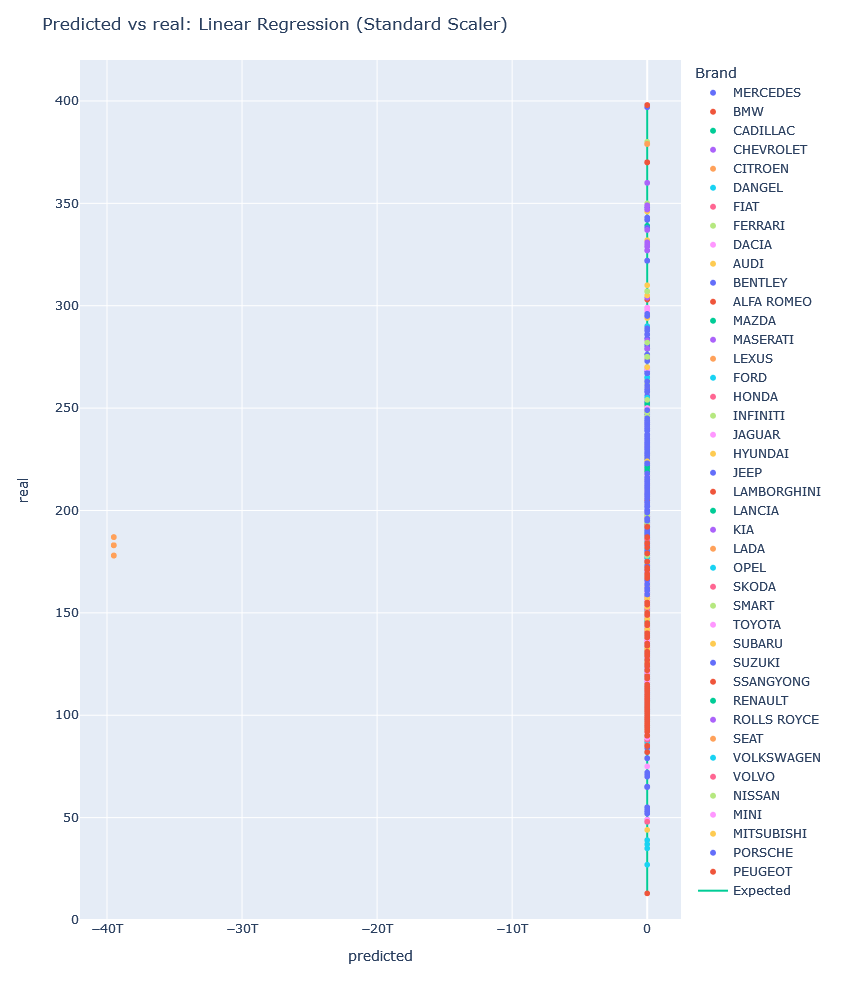

In [54]:
plot_results(y_test, lr_test_pred,"Linear Regression (Standard Scaler)")

> It is not clear the reason why it is not performing well for separation by year.
>
> There is two possibilities to solve this problem:
> - Considering a new scaler to normalized our data (i.e. RobustScaler in our case)
> - Use of Regularized Linear Regression to remove some variables

## 6.2 Second attempt considering the RobustScaler

>Let's try to see if using another scaler such as RobustScaler would help to avoid the model to overfit

In [55]:
# Normalization of the data using RobustScaler
X_train_robust = data[~(df.year==2015)]    # Use < 2015 for train
X_test_robust = data[df.year==2015]        # Use 2015 for test

scaler_robust = RobustScaler()
scaler_robust.fit(X_train_robust)

X_train_robust = pd.DataFrame(scaler_robust.transform(X_train_robust))
X_test_robust = pd.DataFrame(scaler_robust.transform(X_test_robust))

display(X_train_robust.head(3))
display(X_test_robust.head(3))

0    1         2     3      4         5         6    7    8    9   ...  \
0  0.95 -2.2  1.198198  0.75 -0.975 -0.415385 -1.214511  0.0  0.0  0.0  ...   
1 -1.00 -2.9  0.283784 -0.25 -1.375 -0.969231 -1.041009  0.0  0.0  0.0  ...   
2 -1.00 -3.0  0.283784 -0.25 -1.375 -0.969231 -1.041009  0.0  0.0  0.0  ...   

    28   29   30   31   32   33   34   35   36   37  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 38 columns]

0         1         2    3     4    5         6    7    8    9   ...  \
0  0.25 -3.499999  0.202703 -0.4 -3.95 -2.6 -1.111987  0.0  0.0  0.0  ...   
1  0.25 -3.499999  0.202703 -0.4 -3.95 -2.6 -1.111987  0.0  0.0  0.0  ...   
2  0.25 -3.599999  0.202703 -0.4 -3.95 -2.6 -1.111987  0.0  0.0  0.0  ...   

    28   29   30   31   32   33   34   35   36   37  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  

[3 rows x 38 columns]

In [56]:
# Instantiate of the model
lr = LinearRegression()
# Train of the model
lr.fit(X_train_robust, y_train)

LinearRegression()

In [57]:
# Prediction of train and test set
lr_train_pred = lr.predict(X_train_robust)
lr_test_pred = lr.predict(X_test_robust)

In [58]:
# Display of the metrics for the Linear Regression model with StandardScaler
results = metrics(X_train, X_test, y_train, y_test, lr_train_pred , lr_test_pred)
save_picke_file(results, os.path.join('models', f'0-Linear Regression (Robust Scaler).pkl'))
results

Score train : 0.9953
Score test  : -29816200138904276.0000
MSE train :   6.43
MSE test  :   56271134375223869440.00
RMSE train :   2.54
RMSE test  :   7501408826.03
MAE train :   1.41
MAE test  :   321447953.97


R2           MAE           MSE          RMSE
Train  9.953000e-01  1.410000e+00  6.430000e+00  2.540000e+00
Test  -2.981620e+16  3.214480e+08  5.627113e+19  7.501409e+09

> The Problem of overfitting is still not solved using another scaler.

In [59]:
# Display of the coefficient of the Linear Regression
coeff_regression(X_train, lr.coef_, lr.intercept_)

|                   |       coeffs |
|:------------------|-------------:|
| intercept         |  2.0692e+11  |
| puiss_max         | -0.42        |
| conso_mixte       | 24.54        |
| co_typ_1          | -0.96        |
| hc                |  0.95        |
| nox               |  0.4         |
| hcnox             | -0.6         |
| masse_ordma_max   |  1.69        |
| cod_cbr_EE        | -5.11631e+09 |
| cod_cbr_EH        | -5.11631e+09 |
| cod_cbr_ES        |  3.23038e+09 |
| cod_cbr_ES/GP     |  3.23038e+09 |
| cod_cbr_FE        |  3.23038e+09 |
| cod_cbr_GH        | -5.11631e+09 |
| cod_cbr_GL        | -5.11631e+09 |
| cod_cbr_GN        |  3.23038e+09 |
| cod_cbr_GN/ES     |  3.23038e+09 |
| cod_cbr_GO        |  3.23038e+09 |
| hybride_non       | -4.19554e+09 |
| hybride_oui       |  4.15115e+09 |
| type_of_gearbox_A |  8.2742e+10  |
| type_of_gearbox_D |  8.2742e+10  |
| type_of_gearbox_M |  8.2742e+10  |
| type_of_gearbox_S |  8.2742e+10  |
| type_of_gearbox_V | -9.23131e+10 |
|

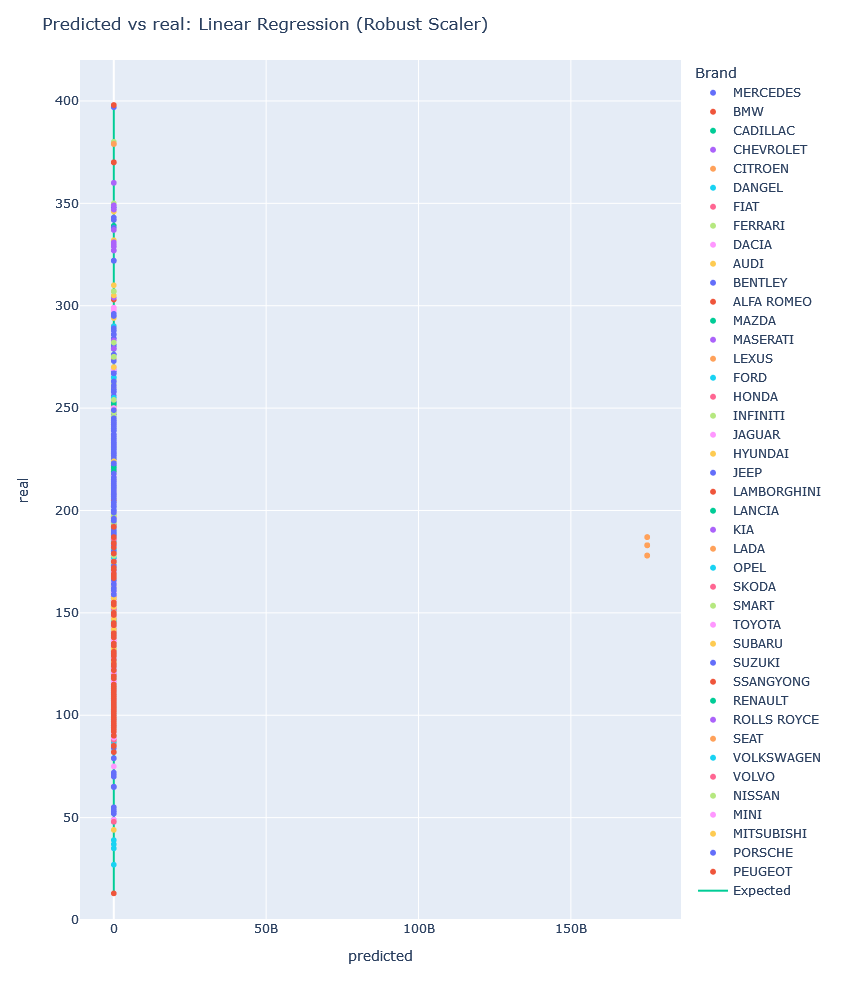

In [60]:
plot_results(y_test, lr_test_pred,"Linear Regression (Robust Scaler)")

> As we can see above, even with a RobustScaler, the model still overfit on the testset. We will therefore try the last solution: use a Regularized Regression

# 7. Regularized Linear Regression

## 7.1. RidgeCV

>The Ridge regression consists in adding a constraint on the coefficients (alpha term) during modeling to control the amplitude of their values. It can solve our previous provlem of overfitting.

> As we will use a Cross Validation method to select the best alpha, we will split our dataset into 10 folds to have a validation set. For that we will use the KFold function

In [ ]:
# Use of the function KFolds to split the training set into 5 folds
k_folds = KFold(n_splits = 10)

In [ ]:
# Creation of a list of alphas that will be used as a hyperparameters
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.5, 0.7, 1, 5 , 10, 20, 30, 40, 75, 100, 200, 500, 700, 1000, 10000, 50000]

# Instantiate of the RidgeCV model
ridge_reg = RidgeCV(alphas = alphas, cv = k_folds)

# Train of the model
ridge_reg.fit(X_train, y_train)

In [ ]:
# Save model to pickle
save_picke_file(ridge_reg, os.path.join('models', f'0-RidgeCV.pkl'))

In [ ]:
# Prediction of train and test set
ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

In [ ]:
# Display of the retained alpha
print(f'The selected alpha is: {ridge_reg.alpha_}')

In [ ]:
scores = cross_val_score(ridge_reg, X_test, y_test, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

In [ ]:
# Display of the coefficient of the RidgeCV Regression
coeff_regression(X_train, ridge_reg.coef_, ridge_reg.intercept_)

In [ ]:
# Display of the main metrics
results = metrics(X_train, X_test, y_train, y_test, lr_train_pred , lr_test_pred)
save_picke_file(results, os.path.join('models', f'0-Results Ridge Regression.pkl'))
results

> Linear Regression is based on two assumptions about errors: homo-sedasticity and normality.
> Let's study now the residues of our model to ensure the compliance of these assumptions
>
> To do that, we will represent in two different graphs:
> - The residues as a function of the target variable to have an estimate of the homoscedasticity of the residues
> - A Quantile-Quantile or (Q-Q plot) diagram

In [ ]:
# Plot of the two graphs
plot_residues(y_train, ridge_pred_train)

> Let's firt analyse the first plot: Normally it should be randomly scattered around y = 0 with no apparent structure. Here it seems that there is no clear structure in their distribution and the points are evenly distributed around y = 0.
>
> We can implement the Breusch-Pagan test to check if the homo-sedasticity is present.
> The hypothesis are the following:
> - Null Hypothesis (H0): homo-sedasticity is present (the residuals are distributed with equal variance)
> - Alternative Hypothesis (H1): Heteroscedasticity is present (the residuals are not distributed with equal variance)
>
> Let's now analyse the Theoretical quantiles graph: The normality of the residues is validated if the point are aligned with the first bisector. Here we can see that this not the case.
>
> We can implement the Jarque-Bera Test to check the normality of the residues. The hypothesis are the following:
> - Null Hypothesis (H0): Data follow a normal distribution.
> - Alternative Hypothesis (H1): Data does not follow a normal distribution.

In [ ]:
# Conduct of both test
statistical_residues(X_train, y_train, ridge_pred_train)

> We can see that p-value < 0.05 therefore we can reject the Null Hypothesis and we conclude H1.So Heteroscedasticity is present
> 
> We can see that p-value < 0.05 therefore we can reject the Null Hypothesis and we conclude H1.So Data doesn't follow a normal distribution
>
> Conclusion: Our model doesn't respect the two assumptions about homo-sedasticity and normality of the errors.

In [ ]:
# Plot of the Predicted vs Actual CO2 Emissions for the Ridge Regression Model
plot_results(y_test, ridge_pred_test,"Ridge Regression")

> Conclusion: Even if the statistical tests are not respected, the predictions of the model are very good.

## 7.2. Lasso

> We will now ty a new type of model: the Lasso Regression. This model is quite similar to the Ridge Regression but it allows to select only interesting variables and remove the others. It is a way to reduce our dataset.
> 
> The penalty coefficient is very important: the higher is the penalty coefficient, the higher the number of coefficients will be estimated at 0 and therefore the variables will be removed.
> 
> Let's first train a Lasso model using a penalty coefficient of 1 which correspond to a high values (meaning that a lot of variables will have their coeffcients equal to 0).

In [ ]:
# Instantiate of the Lasso Model with alpha equal to 1
lasso_r = Lasso(alpha=1.0)
# Train of the model
lasso_r.fit(X_train, y_train)

In [ ]:
# Save model to pickle
save_picke_file(lasso_r, os.path.join('models', f'0-Lasso.pkl'))

In [ ]:
# Prediction of train and test set
lasso_pred_train = lasso_r.predict(X_train)
lasso_pred_test = lasso_r.predict(X_test)

In [ ]:
# Display of the coefficient of the Lasso Regression for alpha = 1
coeff_regression(X_train, lasso_r.coef_, lasso_r.intercept_)

In [ ]:
# Display of a graph represented the estimated coefficients
pd.DataFrame(lasso_r.coef_, index = X_train.columns)

plt.figure(figsize = (10, 5))
plt.bar(X_train.columns, lasso_r.coef_)
plt.xticks(rotation = 70)
plt.title("Coeffcients of the Lasso Regression for alpha = 1")
plt.ylabel("Coefficients")
plt.xlabel("Variables")
plt.show()

> Using a alpha equal to 1, we can see that only 7 variables are kept:
>- Conso_mixte
>- cp_typ_1
>- hc
>- mass_orda_max
>- cod_cbr_FE
>- cod_cbr_GN
>- cod_cbr_GO

In [ ]:
# Display of the main metrics
results = metrics(X_train, X_test, y_train, y_test, lr_train_pred , lr_test_pred)
save_picke_file(results, os.path.join('models', f'0-Results Lasso Regression (alpha=1).pkl'))
results

> Let's perform the statistical test and represents the two dedicated graph:

In [ ]:
# Plot of the two graphs
plot_residues(y_train, lasso_pred_train)

In [ ]:
# Conduct of both test
statistical_residues(X_train, y_train, lasso_pred_train)

> Despite keeping only 7 variables under 38 initially, we can conclude that once again the main assumptions of a linear regression are not respected.

In [ ]:
# Plot of the Predicted vs Actual CO2 Emissions for the Lasso Regression Model
plot_results(y_test, lasso_pred_test,"Lasso Regression (alpha=1)")

> To Conclude, this first Lasso model is very interesting because with only 7 variables, we can see that the prediction score is already very high and the prediction curve is also very good.
>
> We can remark that in this case, the model has some difficulties to predict some car between 150 and 200 g/km of CO2 emissions. The model also have the same difficulties to predict the mercedes brand between 250 and 300 g/km.
>
> The next model will focus on selection the optimal alphas by cross-validation based on predictive performance.

## 7.3. LassoCV

> We have seen in the previous part that the penalty coefficient alpha is very important. If alpha is too high, all regression coeffcients are equal to 0 but if alpha is too low, we keep all our variables.
>
> The aim of this part is to use the LassoCV function to select the optimal alpha that maximize the predictions results.

> Before using LassoCV, we will us the function lasso_path that will allow us to produce the estimated coefficients for different alphas:

In [ ]:
# Creation of a list of alphas
alpha_list = (1e-4, 1e-3, 0.01, 0.02, 0.025, 0.05, 0.075, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9, 1.0)

In [ ]:
# Calculations of the different coefs for all the alphas
alpha_path, coefs_lasso, _ = lasso_path(
    X_train, 
    y_train,
    alphas = alpha_list)

In [ ]:
# Plot of the coefficients for different alphas
title="Lasso coefs vs Alpha"

fig = make_subplots(
    rows=2, cols=1, 
    shared_xaxes=True, x_title='alphas',
    y_title='lasso coefs',
    vertical_spacing = 0.05
)

fig.add_trace(
        go.Scatter(
            x=[f'{a}' for a in alpha_list], 
            y=coefs_lasso[1],
            mode='markers',
            name=f'{X_train.columns[1]}'
        ),
        row=1,col=1
    )

for i in range(1, coefs_lasso.shape[1]):
    if i != 1:
        fig.add_trace(
            go.Scatter(
                x=[f'{a}' for a in alpha_list], 
                y=coefs_lasso[i],
                mode='markers',
                name=f'{X_train.columns[i]}'
            ),
            row=2,col=1
        )

fig.update_layout(
    title=title,
    height=600
)

fig.show()
# Save image as SVG and pickle files
save_picke_file(fig, os.path.join('imgs', f'0-{title}.pkl'))
fig.write_image(os.path.join('imgs',f'0-{title}.svg'), width=1600, height=1000)

> We can see that the variable conso_mixte has a much higher coefficient compared to the other variables (upper subplot).
>
> We can also see that most of the features start being selected for  𝛼 > 0.05.

> We will now use the LassoCV Function to select the alpha that maximize the prediction results

In [ ]:
# Use of the function KFolds to split the training set into 10 folds
k_folds = KFold(n_splits = 10)

In [ ]:
# Instantiate of the Lasso model
model_lasso = LassoCV(alphas=alpha_list, cv = k_folds)
# Train of the model
model_lasso.fit(X_train, y_train)

In [ ]:
# Save model to pickle
save_picke_file(model_lasso, os.path.join('models', f'0-LassoCV.pkl'))

In [ ]:
# Prediction of train and test set
lassocv_pred_train = model_lasso.predict(X_train)
lassocv_pred_test = model_lasso.predict(X_test)

In [ ]:
# Display of the retained alpha
print(f'The selected alpha is: {model_lasso.alpha_}')

In [ ]:
# MSE values for different alpha
alphas = model_lasso.alphas_
mses =  model_lasso.mse_path_
mses_t = np.transpose(mses)

In [ ]:
# lot of the MSE for different alphas
title = "LassoCV MSE vs Alphas"
fig = make_subplots(
    x_title='alphas',
    y_title='MSE'
)

for i in range(mses_t.shape[0]):
    fig.add_trace(
        go.Scatter(
            x=[f'{a}' for a in alphas[::-1]], 
            y=mses_t[::-1][i],
            mode='markers',
            name=f'sample {i+1:02}'
        )
    )

fig.update_layout(
    title=title,
    height=600
)

fig.show()
# Save image as SVG and pickle files
save_picke_file(fig, os.path.join('imgs', f'0-{title}.pkl'))
fig.write_image(os.path.join('imgs',f'0-{title}.svg'), width=1600, height=1000)

> We can see that for all the Cross Validation samples, the MSE is minimised for 𝛼 greater than or equal to 0.1.

In [ ]:
# Display of the coefficient of the Lasso Regression for the best alpha
coeff_regression(X_train, model_lasso.coef_, model_lasso.intercept_)

> The selected alpha is equal to 0.01 so more variables will be kept comparing to the last model. It means that a lot of variables contain some information that are interesting to predict the CO2 emissions. At the end, only 10 variables have their coefficients equal to 0 so 28 variables have coefficients different from 0.

In [ ]:
# Display of the main metrics
metrics(X_train, X_test, y_train, y_test, lassocv_pred_train, lassocv_pred_test)

> We can see that the metrics are very good and better than the previous Lasso model with alpha = 1.

In [ ]:
# Plot of the two graphs
plot_residues(y_train, lassocv_pred_train)

In [ ]:
# Conduct of both test
statistical_residues(X_train, y_train, lassocv_pred_train)

> The statistical tests show that the main assumptions of the Linear Regression are still not respected.

In [ ]:
# Plot of the Predicted vs Actual CO2 Emissions for the Lasso Regression Model with the best alpha
plot_results(y_test, lassocv_pred_test,"Predicted vs actual value for the Lasso Regression Model with the best alpha")

> To conclude on this model, the LassoCV allow to select the best alpha that maximise the results. We can see that the results are better than the previous Lasso model with alpha = 1 meaning that a lot of our variables present some interesting information to predict the CO2 emissions of the cars.
>
> If we compare now this model with the RidgeCV model, we can see that the results are almost identical, but the LassoCV only used 28 variables compared to the RidgCV model where all the variables was used. It means that the 10 removed variables don't give additional information.
>
> Let's now used the last Regularized Regression model: ElasticNetCV.

## 7.4. ElasticNetCV

> In this part, we will use a last model ElasticNetCV. This model have a penalty coefficient which is a combination of L1 and L2 penalties. This model is interesting because it allows to exclude irrelevant variables such as Lasso Model but also sharing weights between correlated variables.
>
> In this case, will use a list of alphas and l1_ratio and perform a cross validation to select the best combination to have the best predictions results.

In [ ]:
# Creation of a list of alphas and l1_ratios
l1_ratio = (0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99)
alpha_list = (1e-4, 1e-3, 0.01, 0.025, 0.05, 0.075, 0.09, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0)

In [ ]:
# Use of the function KFolds to split the training set into 10 folds
k_folds = KFold(n_splits = 10)

In [ ]:
# Instantiate of the model
model_en = ElasticNetCV(
    l1_ratio = l1_ratio,
    alphas = alpha_list,
    cv = k_folds)

# train of the model
model_en.fit(X_train, y_train)

In [ ]:
# Save model to pickle
save_picke_file(model_en, os.path.join('models', f'0-ElasticNetCV.pkl'))

In [ ]:
# Prediction of train and test set
elastic_pred_train = model_en.predict(X_train)
elastic_pred_test = model_en.predict(X_test)

In [ ]:
# Display of the retained alpha
print(f'The selected alpha is: {model_en.alpha_}')
print(f'The selected l1_ratio is: {model_en.l1_ratio_}')

In [ ]:
# MSE values for different alpha
alphas = model_en.alphas_
mses =  model_en.mse_path_
mses_t = np.transpose(mses)

In [ ]:
# Plot of the MSE for different alphas
title = 'ElasticNetCV: MSE vs Alphas'
fig = make_subplots(
    x_title='alphas',
    y_title='MSE'
)

for i in range(0, len(model_en.l1_ratio)):
    fig.add_trace(
        go.Scatter(
            x=[f'{a}' for a in alphas[::-1]], 
            y= model_en.mse_path_[i,:,:].mean(axis = 1),
            mode='markers',
            name='Mean for l1_ratio= %.2f' %model_en.l1_ratio[i]
        )
    )

fig.update_layout(
    title=title,
    height=600
)

fig.show()
# Save image as SVG and pickle files
save_picke_file(fig, os.path.join('imgs', f'0-{title}.pkl'))
fig.write_image(os.path.join('imgs',f'0-{title}.svg'), width=1600, height=1000)

>We can see that the MSE is very low for alphas greater than 0.1. The minimum value is reached for alpha around 1.

In [ ]:
# Display of the coefficient of the Lasso Regression for the best alpha
coeff_regression(X_train, model_en.coef_, model_en.intercept_)

In [ ]:
# Display of the main metrics
metrics(X_train, X_test, y_train, y_test, elastic_pred_train, elastic_pred_test)

In [ ]:
# Plot of the two graphs
plot_residues(y_train, elastic_pred_train)

In [ ]:
# Conduct of both test
statistical_residues(X_train, y_train, elastic_pred_train)

In [ ]:
# Plot of the Predicted vs Actual CO2 Emissions for the ElasticNetCV Model
plot_results(y_test, elastic_pred_test,"Predicted vs actual value for the ElasticNet Regression Model with the best alpha")

>To conclude the results are very close to the ones obtained by the ElasticNetCV model.  The scatterplot shown above confirms the very good predictions of the model.

## 7.5. Summary

In [ ]:
# RidgeCV
# ---
print('RidgeCV\n---')
ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

# Display MSE
ridge_mse_train = mean_squared_error(y_train, ridge_pred_train)
ridge_mse_test = mean_squared_error(y_test, ridge_pred_test)
print(f'MSE train   : {ridge_mse_train:.4f}')
print(f'MSE test    : {ridge_mse_test:.4f}')

# Display R2
ridge_score_train = ridge_reg.score(X_train, y_train)
ridge_score_test = ridge_reg.score(X_test, y_test)
print(f'Score train : {ridge_score_train:.4f}')
print(f'Score test  : {ridge_score_test:.4f}')

# LassoCV
# ---
print('\nLassoCV\n---')
lasso_pred_train = model_lasso.predict(X_train)
lasso_pred_test = model_lasso.predict(X_test)

# Display MSE
lasso_mse_train = mean_squared_error(y_train, lasso_pred_train)
lasso_mse_test = mean_squared_error(y_test, lasso_pred_test)
print(f'MSE train   : {lasso_mse_train:.4f}')
print(f'MSE test    : {lasso_mse_test:.4f}')

# Display R2
lasso_score_train = model_lasso.score(X_train, y_train)
lasso_score_test = model_lasso.score(X_test, y_test)
print(f'Score train : {lasso_score_train:.4f}')
print(f'Score test  : {lasso_score_test:.4f}')

# ElasticNetCV
# ---
print('\nElasticNetCV\n---')
elasticn_pred_train = model_en.predict(X_train)
elasticn_pred_test = model_en.predict(X_test)

# Display MSE
elasticn_mse_train = mean_squared_error(y_train, elasticn_pred_train)
elasticn_mse_test = mean_squared_error(y_test, elasticn_pred_test)
print(f'MSE train   : {elasticn_mse_train:.4f}')
print(f'MSE test    : {elasticn_mse_test:.4f}')

# Display R2
elasticn_score_train = model_en.score(X_train, y_train)
elasticn_score_test = model_en.score(X_test, y_test)
print(f'Score train : {elasticn_score_train:.4f}')
print(f'Score test  : {elasticn_score_test:.4f}')

In [ ]:
models = ['RidgeCV', 'LassoCV', 'ElasticNetCV']

MSE_train = [ridge_mse_train, lasso_mse_train, elasticn_mse_train]
MSE_test = [ridge_mse_test, lasso_mse_test, elasticn_mse_test]

score_train = [ridge_score_train, lasso_score_train, elasticn_score_train]
score_test = [ridge_score_test, lasso_score_test, elasticn_score_test]

In [ ]:
fig = make_subplots(
    rows=2, 
    cols=1, 
    shared_xaxes=True, 
    vertical_spacing = 0.01, 
    row_heights=[0.40, 0.60]
)

#  FIRST ROW
# ------------------------
fig.add_trace(
     go.Scatter(
        x=models, 
        y=MSE_train, 
        name="MSE train", 
        mode="markers+text",
        text=[f'{x:.2f}' for x in MSE_train],
        textposition="top center"
    ),
    row=1, col=1
)

fig.add_trace(
     go.Scatter(
        x=models, 
        y=MSE_test, 
        name="MSE test", 
        mode="markers+text",
        text=[f'{x:.2f}' for x in MSE_test],
        textposition="top center"
    ),
    row=1, col=1
)

#  SECOND ROW
# ------------------------
fig.add_trace(
    go.Bar(
        x=models, 
        y=score_train,
        text=[f'{x:.3f}' for x in score_train],
        textfont_color="black",
        textposition="outside",
        name="Score train"),
    row=2, col=1
)


fig.add_trace(
    go.Bar(
        x=models, 
        y=score_test,
        text=[f'{x:.3f}' for x in score_test],
        textfont_color="black",
        textposition="outside",
        name="Score test"),
    row=2, col=1
)
title="Regression Models: Results Summary"
# Add figure title
fig.update_layout(
    title_text=title,
    template="plotly",
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1.02,xanchor="right", 
        x=1),
    height=600
)

# Set x-axis title
# ------------------------
fig['layout']['yaxis']['title']='MSE'
fig['layout']['yaxis2']['title']='Score'
fig['layout']['xaxis2']['title']='MODEL'
# Y axis scale
fig['layout']['yaxis']['range']=[0,25]
fig['layout']['yaxis2']['range']=[0,1.19]

fig.show()
# Save image as SVG and pickle files
save_picke_file(fig, os.path.join('imgs', f'0-{title}.pkl'))
fig.write_image(os.path.join('imgs',f'0-{title}.svg'), width=1600, height=1000)

> Overall Conclusion: We can see that all of them perform very well. We managed to fix the problem of overfitting and get a score above 99% for our test dataset. Although the models have slightly different MSE for the test set, their differences are negligible, and we can say that their performance are the same. Any of the 3 regularized models developed in this study can then be used as a good estimator for CO2 emissions prediction.

# 8. Neural Networks

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Activation, Input
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from keras.utils import to_categorical

# 9. Data Viz

In [ ]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
y_pred = model_en.predict(X)

In [ ]:
fig = plt.figure(figsize=(20,12))

for year in [2012, 2013, 2014, 2015]:

    criteria = (df.year==year) & ~(df.hybride=='oui')
    criteria2 = (df.year==year) & (df.hybride=='oui')
    
    ax = fig.add_subplot(2,2,year-2011)    
    ax.scatter(
        y_pred[criteria], 
        y[criteria],
        label='model-non-hybrid'
    )
    ax.scatter(
        y_pred[criteria2], 
        y[criteria2], 
        label='model-hybrid'
    )
    ax.plot(
        [min(y[criteria].min(), y[criteria2].min()), max(y[criteria].max(), y[criteria2].max())],
        [min(y[criteria].min(), y[criteria2].min()), max(y[criteria].max(), y[criteria2].max())],
        '--r',
        label='expected'
    )
    
    ax.set_ylabel('predicted')
    ax.set_xlabel('value')
    ax.set_title(f'Predicted vs Actual Value ({year=})')
    plt.legend()
plt.savefig('imgs\z-Predicted vs Actual Value.png', bbox_inches='tight')
plt.show()

In [ ]:
df2 = df[['co2', 'year', 'hybride', 'type_of_gearbox', 'nbr_reports']]
df2['y_pred'] = y_pred
df2

In [ ]:
fig = px.scatter(
    data_frame=df2,
    x='y_pred',
    y='co2',
    hover_name=df['lib_mrq_utac'],
    color='type_of_gearbox',
    labels={
        'y_pred':'predicted',
        'co2':'real',
        'type_of_gearbox':'Gearbox'
    }
)

fig.update_layout(
    title='Predicted vs actual value',
    height=600,
)
fig.add_scatter(
    x = [df2.co2.min(), df2.co2.max()],
    y = [df2.co2.min(), df2.co2.max()],
    name = 'expected',
    mode = 'lines'
)

fig.show()

In [ ]:
# fig = plt.figure(figsize=(16,6))
# ax = fig.add_subplot(111)

# sns.scatterplot(
#     data=df2,
#     x='y_pred',
#     y='co2',
#     hue='type_of_gearbox',
#     ax=ax
# )

# ax.plot(
#     [df2.y_pred.min(), df2.y_pred.max()],
#     [df2.y_pred.min(), df2.y_pred.max()],
#     '--r',
#     label='expected'
# )
# ax.set_ylabel('predicted')
# ax.set_xlabel('value')

# plt.show()

In [ ]:
def plot_brand_per_year(brand, show_fig=True):
    fig = plt.figure(figsize=(20,10))
    # brand = 'MERCEDES'
    fig.suptitle(f'Predictions for {brand}')
    for year in [2012, 2013, 2014, 2015]:
        criteria = (df.year==year) & ~(df.hybride=='oui') & (df.lib_mrq_utac==brand)
        criteria2 = (df.year==year) & (df.hybride=='oui') & (df.lib_mrq_utac==brand)
        
        ax = fig.add_subplot(2,2,year-2011)    
        ax.scatter(
            y_pred[criteria], 
            y[criteria],
            label='model-non-hybrid'
        )
        ax.scatter(
            y_pred[criteria2], 
            y[criteria2], 
            label='model-hybrid'
        )
        ax.plot(
            [min(y[criteria].min(), y[criteria2].min()), max(y[criteria].max(), y[criteria2].max())],
            [min(y[criteria].min(), y[criteria2].min()), max(y[criteria].max(), y[criteria2].max())],
            '--r',
            label='expected'
        )
        
        ax.set_ylabel('predicted')
        ax.set_xlabel('value')
        ax.set_title(f'Predicted vs Actual Value ({year=})')
        plt.legend()
    
    # MSE = mean_squared_error(y[criteria], y_pred[criteria])
    # R2 = model_en.score(X[criteria], df.co2[criteria])
    # fig.suptitle(f'Predictions for {brand} ({MSE=:.2f})')
    # f'MSE test    : {mean_squared_error(y_test, elasticn_pred_test):.4f}'
    plt.savefig(f'imgs\z-Predictions for {brand}.png', bbox_inches='tight')
    if show_fig:
        plt.show()
    
plot_brand_per_year('MERCEDES')

In [ ]:
for brand in df.lib_mrq_utac.unique():
    plot_brand_per_year(brand, show_fig=False)

In [ ]:
plot_brand_per_year('VOLKSWAGEN')

In [ ]:
plot_brand_per_year('BMW')

In [ ]:
plot_brand_per_year('OPEL')

In [ ]:
plot_brand_per_year('DACIA')

In [ ]:
plot_brand_per_year('JEEP')